In [2]:
import google.datalab.bigquery as bq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

In [4]:
# Create and run a SQL query
query = bq.Query('(SELECT * FROM `bigquery-public-data.new_york.tlc_yellow_trips_2015` LIMIT 50000) union all (SELECT * FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016` LIMIT 50000)')
output_options = bq.QueryOutput.table(use_cache=False)
result = query.execute(output_options=output_options).result()

In [5]:
# Convert to DataFrame
df = result.to_dataframe()
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount
0,1,2016-04-03 10:57:51,2016-04-03 11:18:59,2,7.20,-73.997177,40.716515,1.0,N,-73.954987,40.777653,1,23.0,0.0,0.5,4.75,0.0,0.3,28.55
1,1,2016-07-05 00:11:29,2016-07-05 00:33:31,1,8.80,NaN,NaN,1.0,N,NaN,NaN,1,27.0,0.5,0.5,5.65,0.0,0.3,33.95
2,2,2016-02-29 08:52:02,2016-02-29 09:30:42,2,5.84,-73.970963,40.790916,1.0,N,-73.991661,40.731342,1,27.0,0.0,0.5,2.78,0.0,0.3,30.58
3,2,2016-01-17 16:33:57,2016-01-17 17:01:37,5,6.92,-73.956718,40.780960,1.0,N,-74.001740,40.730331,1,25.0,0.0,0.5,5.16,0.0,0.3,30.96
4,1,2016-01-30 00:42:39,2016-01-30 01:08:33,1,6.40,-74.005386,40.720814,1.0,N,-73.929634,40.685833,1,23.0,0.5,0.5,6.05,0.0,0.3,30.35


/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


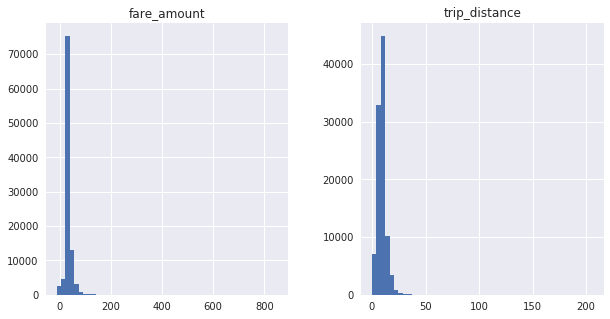

In [6]:
# Check the distribution of trip_distance and fare_amount
df[['trip_distance','fare_amount']].hist(figsize = (10,5), bins=50);

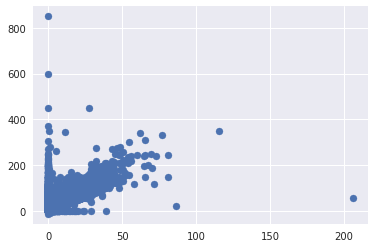

In [51]:
plt.scatter(df['trip_distance'], df['fare_amount']);

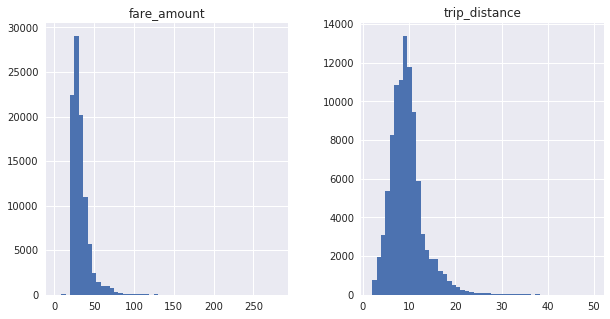

In [59]:
# Remove those rows with very low or very high fare_amount or trip_distance
df_filtered = df[(df['trip_distance'] >= 2) & (df['trip_distance'] <= 50) & (df['fare_amount'] >= 3) & (df['fare_amount'] <=300)]
df_filtered[['trip_distance','fare_amount']].hist(figsize = (10,5), bins=50);

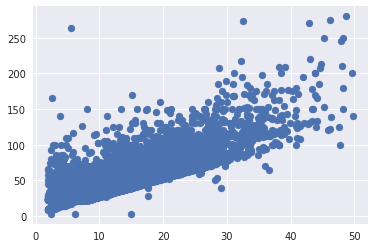

In [60]:
plt.scatter(df_filtered['trip_distance'], df_filtered['fare_amount']);

In [61]:
# Split Training and Testing set based on year
df_filtered['pickup_datetime'] = pd.to_datetime(df_filtered['pickup_datetime'])
df_filtered['year'] = df_filtered['pickup_datetime'].dt.year
Train_df = df_filtered[df_filtered['year'] == 2015]
Test_df = df_filtered[df_filtered['year'] == 2016]
Train_df.head()

/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,year
50000,2,2015-09-16 12:37:48,2015-09-16 13:24:04,1,4.22,-74.017975,40.706524,1.0,N,-73.976768,40.749699,1,28.0,0.0,0.5,5.76,0.00,0.3,34.56,2015
50001,1,2015-08-02 12:09:26,2015-08-02 12:32:25,1,9.90,-73.985802,40.759350,1.0,N,-73.871193,40.774082,1,30.0,0.0,0.5,7.25,5.54,0.3,43.59,2015
50002,2,2015-09-25 18:47:43,2015-09-25 19:19:22,1,5.94,-73.980576,40.748310,1.0,N,-73.919113,40.774849,1,25.0,1.0,0.5,5.36,0.00,0.3,32.16,2015
50003,1,2015-11-19 19:21:03,2015-11-19 19:49:16,1,6.50,-73.966995,40.756790,1.0,N,-73.994476,40.694447,1,22.5,1.0,0.5,4.85,0.00,0.3,29.15,2015
50004,1,2015-10-01 02:28:52,2015-10-01 02:58:04,1,9.00,-73.993660,40.756805,1.0,N,-73.903473,40.695274,1,28.5,0.5,0.5,3.20,0.00,0.3,33.00,2015


In [101]:
# Simple univariate model
y_train = Train_df['fare_amount']
X_train = Train_df['trip_distance'].reshape(-1, 1)
lm = LinearRegression().fit(X_train,y_train)
y_train_pred = lm.predict(X_train)
print("----Training Data results (2015 data set)----")
print("RMSE: ${:.1f}".format(sqrt(mean_squared_error(y_train, y_train_pred))))
print("R2: {:.2f}\n".format(r2_score(y_train, y_train_pred)))

y_test = Test_df['fare_amount']
X_test = Test_df['trip_distance'].reshape(-1, 1)
y_test_pred = lm.predict(X_test)
print("----Test Data results (2016 data set)----")
print("RMSE: ${:.1f}".format(sqrt(mean_squared_error(y_test, y_test_pred))))
print("R2: {:.2f}\n".format(r2_score(y_test, y_test_pred)))

----Training Data results (2015 data set)----
RMSE: $6.9
R2: 0.68

----Test Data results (2016 data set)----
RMSE: $6.9
R2: 0.70



/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()
/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


# Feature Engineering
Add in features as below
1. Pickup month
2. Pickup day of the week
3. Pickup hour of the day
4. Lattitude difference
5. Longitude difference

In [63]:
df_filtered['month'] = df_filtered['pickup_datetime'].dt.month
df_filtered['day_of_week'] = df_filtered['pickup_datetime'].dt.weekday_name
df_filtered['hour_of_day'] = df_filtered['pickup_datetime'].dt.hour
df_filtered['lat_dif'] = abs(df_filtered['pickup_latitude'] - df_filtered['dropoff_latitude'])
df_filtered['lon_dif'] = abs(df_filtered['pickup_longitude'] - df_filtered['dropoff_longitude'])
df_filtered.head()

/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,...,tip_amount,tolls_amount,imp_surcharge,total_amount,year,month,day_of_week,hour_of_day,lat_dif,lon_dif
0,1,2016-04-03 10:57:51,2016-04-03 11:18:59,2,7.20,-73.997177,40.716515,1.0,N,-73.954987,...,4.75,0.0,0.3,28.55,2016,4,Sunday,10,0.061138,0.042191
1,1,2016-07-05 00:11:29,2016-07-05 00:33:31,1,8.80,NaN,NaN,1.0,N,NaN,...,5.65,0.0,0.3,33.95,2016,7,Tuesday,0,NaN,NaN
2,2,2016-02-29 08:52:02,2016-02-29 09:30:42,2,5.84,-73.970963,40.790916,1.0,N,-73.991661,...,2.78,0.0,0.3,30.58,2016,2,Monday,8,0.059574,0.020699
3,2,2016-01-17 16:33:57,2016-01-17 17:01:37,5,6.92,-73.956718,40.780960,1.0,N,-74.001740,...,5.16,0.0,0.3,30.96,2016,1,Sunday,16,0.050629,0.045021
4,1,2016-01-30 00:42:39,2016-01-30 01:08:33,1,6.40,-74.005386,40.720814,1.0,N,-73.929634,...,6.05,0.0,0.3,30.35,2016,1,Saturday,0,0.034981,0.075752


In [102]:
Train_df_aug = df_filtered[df_filtered['year'] == 2015]
Test_df_aug = df_filtered[df_filtered['year'] == 2016]

In [103]:
# Multivariate Model
y_train = Train_df_aug['fare_amount']
X_train = Train_df_aug[['trip_distance', 'month', 'day_of_week', 'hour_of_day', 'lat_dif', 'lon_dif']]
X_train_encoded = pd.get_dummies(X_train, columns=['month', 'day_of_week', 'hour_of_day'])
lm = LinearRegression().fit(X_train_encoded,y_train)
y_train_pred = lm.predict(X_train_encoded)
print("----Training Data results (2015 data set)----")
print("RMSE: ${:.1f}".format(sqrt(mean_squared_error(y_train, y_train_pred))))
print("R2: {:.2f}\n".format(r2_score(y_train, y_train_pred)))

y_test = Test_df_aug['fare_amount']
X_test = Test_df_aug[['trip_distance', 'month', 'day_of_week', 'hour_of_day', 'lat_dif', 'lon_dif']]
X_test_encoded = pd.get_dummies(X_test, columns=['month', 'day_of_week', 'hour_of_day'])
mask = ~np.isnan(y_test) & ~np.isnan(X_test_encoded['lat_dif']) & ~np.isnan(X_test_encoded['lon_dif'])
y_test_pred = lm.predict(X_test_encoded[mask])
print("----Test Data results (2016 data set)----")
print("RMSE: ${:.1f}".format(sqrt(mean_squared_error(y_test[mask], y_test_pred))))
print("R2: {:.2f}\n".format(r2_score(y_test[mask], y_test_pred)))

----Training Data results (2015 data set)----
RMSE: $6.7
R2: 0.70

----Test Data results (2016 data set)----
RMSE: $6.5
R2: 0.72

